# Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import warnings
warnings.filterwarnings('ignore')

In [17]:
df = pd.read_csv("dataset_cleaning1.csv")

In [18]:
df.columns

Index(['Age Group', 'Sexual Orientation', 'Race', 'Living Situation',
       'Household Composition', 'Religious Preference', 'Veteran Status',
       'Employment Status', 'Number Of Hours Worked Each Week',
       'Education Status', 'Mental Illness', 'Intellectual Disability',
       'Autism Spectrum', 'Other Developmental Disability',
       'Alcohol Related Disorder', 'Drug Substance Disorder',
       'Opioid Related Disorder', 'Mobility Impairment Disorder',
       'Hearing Impairment', 'Visual Impairment', 'Speech Impairment',
       'Hyperlipidemia', 'High Blood Pressure', 'Diabetes', 'Obesity',
       'Heart Attack', 'Stroke', 'Other Cardiac', 'Pulmonary Asthma',
       'Alzheimer or Dementia', 'Kidney Disease', 'Liver Disease',
       'Endocrine Condition', 'Neurological Condition',
       'Traumatic Brain Injury', 'Joint Disease', 'Cancer',
       'Other Chronic Med Condition', 'No Chronic Med Condition',
       'Unknown Chronic Med Condition', 'Serious Mental Illness',
     

# Feature selection

In [19]:
feature_list = ['Education Status', 'Gender', 'Smoke(d)', 'Pulmonary Asthma', 'Sexual Orientation', 'Cannabis use', 'Living Situation', 'No Insurance', 'Household Composition', 'Brain related disorder', 'Diabetes', 'Speech Impairment', 'High Blood Pressure', 'Employment Status', 'Serious Mental Illness', 'Hyperlipidemia', 'Obesity', 'Liver Disease', 'Neurological Condition', 'Traumatic Brain Injury', 'Joint Disease', "substance related disorder"]

In [20]:
##function to select features manually by input list in a pandas DataFrame
def select_features(df, feature_list):
    return df[feature_list]

In [21]:
df = select_features(df, feature_list)

In [22]:
df.shape

(206612, 22)

# Preparing the data for machine learning model

### Handling the UNKNOWN values in the target column

In this part of the project the defined target will be the column 'substance related disorder' that combine the information from three other columns : 'Alcohol Related Disorder', 'Drug Substance Disorder', 'Opioid Related Disorder'. In this part of the project it is better to not have "UNKNOWN' values in the target column. So I decided to drop the rows where 'substance related disorder' == 'UNKNOWN'

In [23]:
# Keep the rows with no UNKNOWN attribute in 'susbatnce related disorder'
data = df[df["substance related disorder"] != "UNKNOWN"]
print('before dropping the rows:', df.shape)
print('after dropping the rows:', data.shape)

before dropping the rows: (206612, 22)
after dropping the rows: (198801, 22)


### Encoding the data for machine learning

#### Start by splitting the target column from the other features

In [24]:
# Splitting the X and y data

def split_X_y(df, target_col):
    # Split dataframe into X and y
    X = df.drop(target_col, axis=1) 
    y = df[target_col]

    return X, y

X, y = split_X_y(data, "substance related disorder")

#### Encoding the features X

In [25]:
X_encod = pd.get_dummies(X, drop_first = True)

In [26]:
X_encod.shape

(198801, 54)

In [27]:
X_encod.head()

,Education Status_MIDDLE SCHOOL TO HIGH SCHOOL,Education Status_NO FORMAL EDUCATION,Education Status_OTHER,Education Status_PRE-K TO FIFTH GRADE,Education Status_UNKNOWN,Gender_MALE,Gender_NON-BINARY,Gender_TRANSGENDER FEMALE,Gender_TRANSGENDER MALE,Gender_UNKNOWN,...,Obesity_UNKNOWN,Obesity_YES,Liver Disease_UNKNOWN,Liver Disease_YES,Neurological Condition_UNKNOWN,Neurological Condition_YES,Traumatic Brain Injury_UNKNOWN,Traumatic Brain Injury_YES,Joint Disease_UNKNOWN,Joint Disease_YES
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Replace the 'YES', 'NO' into 0 and 1
Knowing that there is no unknown left in the target column I can ony use 0 and 1

In [28]:
y_encod = y.replace({'NO': 0, 'YES': 1})

#### Replace the 'YES', 'NO' into 0 and 1
Cocatenate the X and y in the same table

In [29]:
data_encod = pd.concat([X_encod, y_encod], axis=1)

In [30]:
data_encod.shape

(198801, 55)

### Evaluating the balance between 'Yes' and 'No' attributes in target column

In [31]:
category_No = data_encod[data_encod["substance related disorder"] == 0]
category_Yes = data_encod[data_encod["substance related disorder"] == 1]
print(category_No.shape)
print('')
print(category_Yes.shape)

(163185, 55)

(35616, 55)


We can see that there is an imbalance between the 'YES' and 'NO' attributes in this dataset. We need to handle the imbalance. We will fo this after splitting the data in order to protect the test data from leakage

# Splitting test and train

In [32]:
# Split the dataframe bewteen train and test before upsampling on the train

def split_data(data, test_size=0.2, random_state=42):

    data_train, data_test = train_test_split(data, test_size=test_size, random_state=random_state)
    
    return data_train, data_test

data_train, data_test = split_data(data_encod)

In [33]:
# Check the inbalance in the train data
category_0 = data_train[data_train["substance related disorder"] == 0]
category_1 = data_train[data_train["substance related disorder"] == 1]

print(category_0.shape)
print('')
print(category_1.shape)

(130614, 55)

(28426, 55)


In [34]:
# Check the inbalance in the test data
test_0 = data_test[data_test["substance related disorder"] == 0]
test_1 = data_test[data_test["substance related disorder"] == 1]

print(test_0.shape)
print('')
print(test_1.shape)

(32571, 55)

(7190, 55)


# Downsampling on the train data

In [35]:
# downsample the majority class to the size of the positive class using pandas sample method
c1_len = 28426
category_0_down = category_0.sample(c1_len)
print(category_0_down.shape)
print(category_1.shape)

(28426, 55)
(28426, 55)


In [36]:
# Regroup the data together category_0_down and category_1
data_train_down = pd.concat([category_0_down, category_1], axis=0)
#shuffling the data
data_train_down = data_train_down .sample(frac=1)
print('shape after downsampling and concatenating the tables: ', data_train_down.shape)

shape after downsampling and concatenating the tables:  (56852, 55)


# Splitting X and y from train and test data

In [37]:
# Splitting the train data

def split_X_y(df, target_col):
    # Split dataframe into X and y
    X_train = df.drop(target_col, axis=1) #predictive variables
    y_train = df[target_col] #predicted varuable

    return X_train, y_train

X_train, y_train = split_X_y(data_train_down, "substance related disorder")
X_test, y_test = split_X_y(data_test, "substance related disorder")

In [38]:
print ('shape of X_train:', X_train.shape)
print ('')
print ('shape of X_test:', X_test.shape)

shape of X_train: (56852, 54)

shape of X_test: (39761, 54)


***************************************************************************************************************************
# Random Forest
****************************

In [39]:
from sklearn.ensemble import RandomForestClassifier

rfc_ops = {"max_depth":6,
           "min_samples_leaf":20,
           "max_features":None, #when we put none it means the forest will choose its own
           "n_estimators":100, #n of models
           "bootstrap":True, #random replacement 
           "oob_score":True, #out of bag score: use the records not used for model in validation test
           "random_state":42} #reprosuce the same results

clf = RandomForestClassifier(**rfc_ops)

        #max_depth=6,min_samples_leaf=20,max_features=None,n_estimators=100,
         #                    bootstrap=True,oob_score=True, random_state=RAND_STATE)
clf.fit(X_train, y_train)
print("train prediction accuracy score: %.2f" %(clf.score(X_train, y_train)))
print("test prediction accuracy score: %.2f"  %(clf.score(X_test, y_test)))

train prediction accuracy score: 0.75
test prediction accuracy score: 0.75


,Error_metric,Train,Test
0,Accuracy,0.750106,0.751817
1,Precision,0.749342,0.400505
2,Recall,0.751636,0.749652


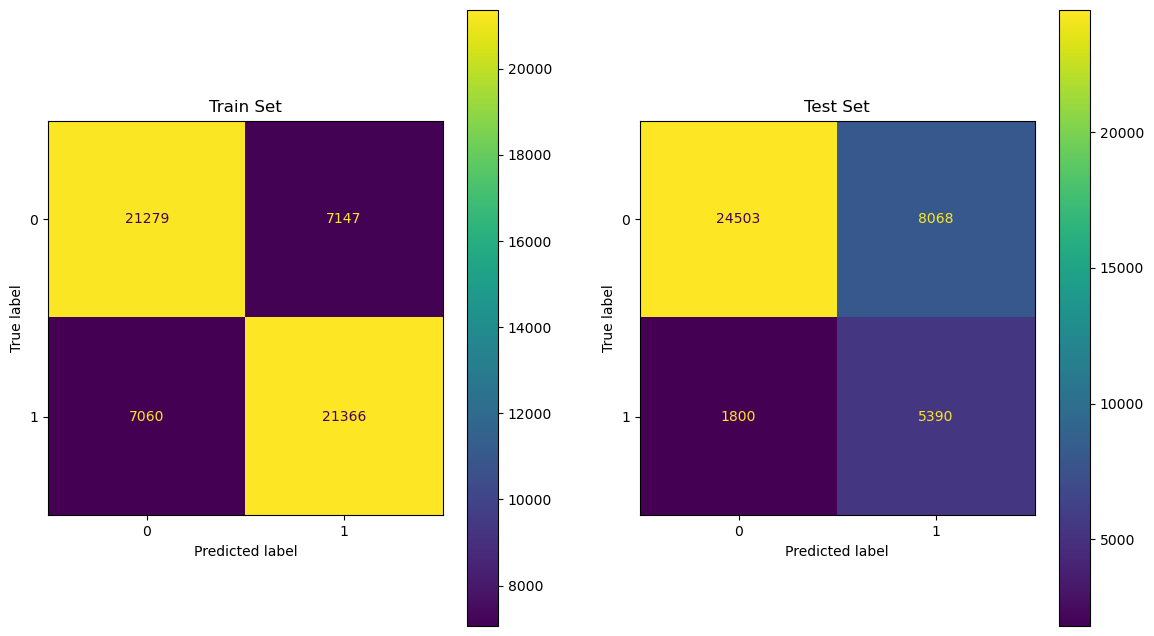

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

y_pred_train_dt = clf.predict(X_train)
y_pred_test_dt = clf.predict(X_test)


performance_df = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_dt),
                                         precision_score(y_train, y_pred_train_dt),
                                         recall_score(y_train, y_pred_train_dt)],
                               'Test': [accuracy_score(y_test, y_pred_test_dt),
                                        precision_score(y_test, y_pred_test_dt),
                                        recall_score(y_test, y_pred_test_dt)]})

display(performance_df)

fig, ax = plt.subplots(1,2, figsize=(14,8))


#print("Confusion matrix for the train set")
#print(confusion_matrix(y_train,y_pred_train_dt).T)
plot_confusion_matrix(clf,X_train,y_train,ax=ax[0], values_format = 'd')
ax[0].title.set_text("Train Set")

#print("Confusion matrix for the test set")

#print(confusion_matrix(y_test,y_pred_test_dt).T)
plot_confusion_matrix(clf,X_test,y_test,ax=ax[1],values_format = 'd')
ax[1].title.set_text("Test Set")

## Features Importances

<BarContainer object of 54 artists>

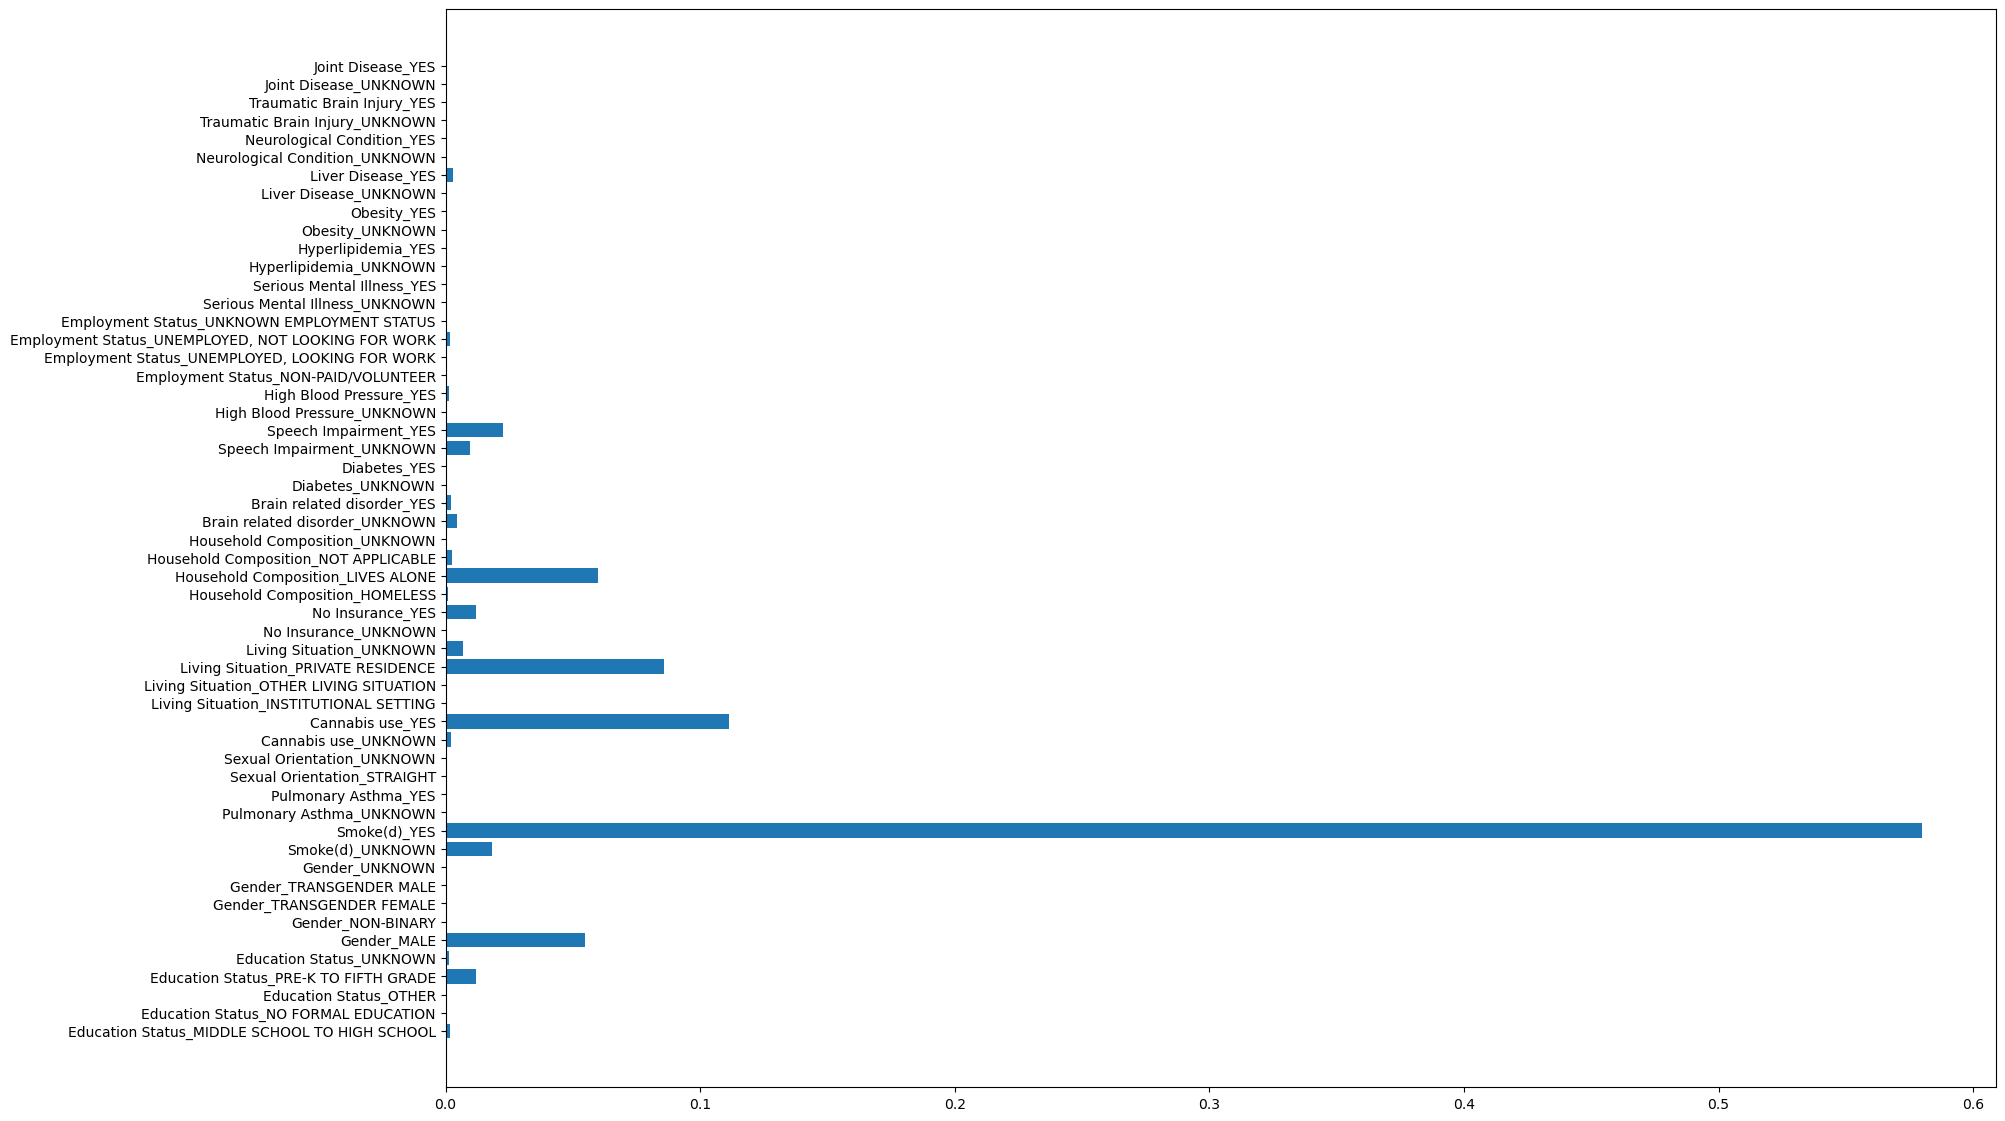

In [41]:
plt.figure(figsize=(20,14))
plt.barh(X_encod.columns,clf.feature_importances_)

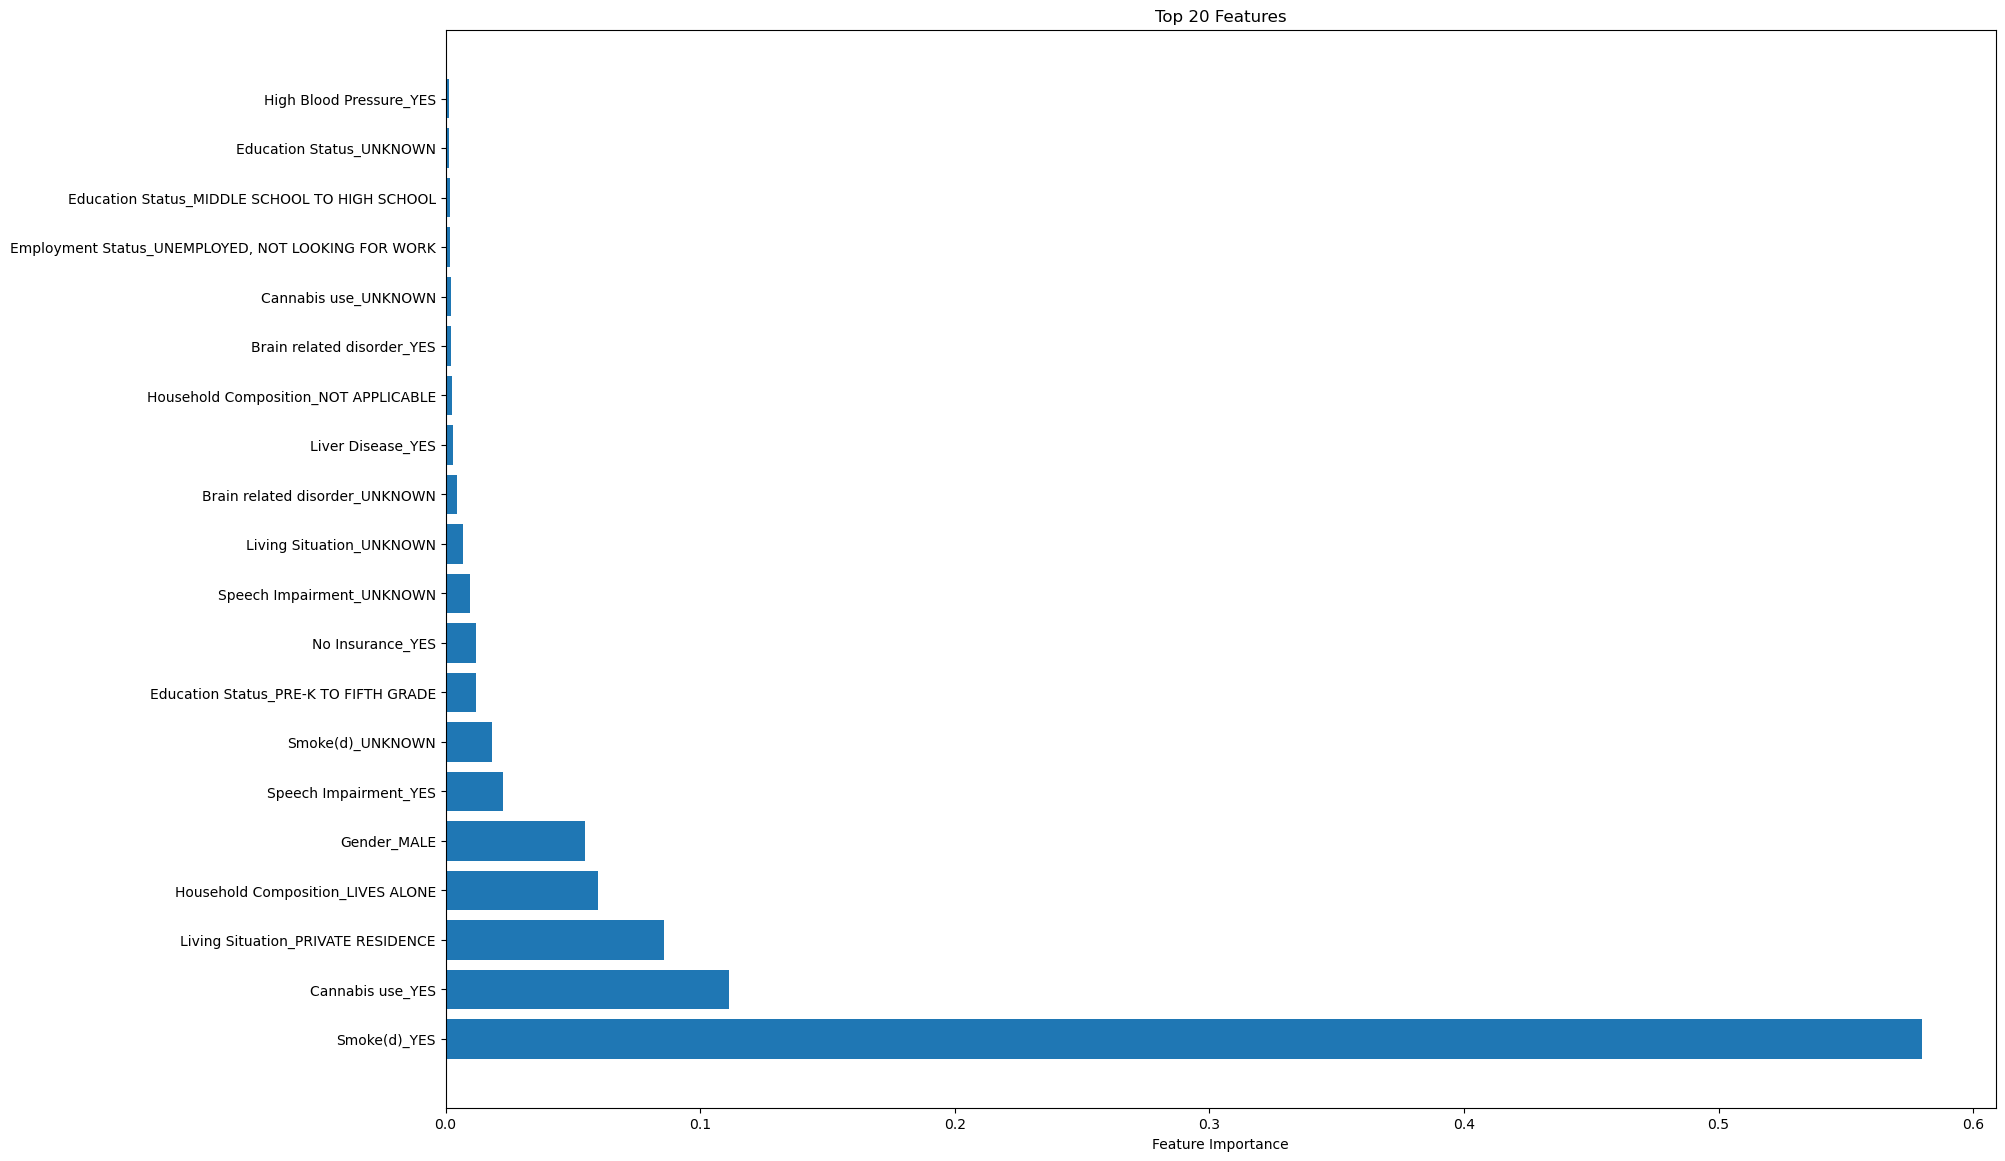

In [42]:
# Sort the features and select only top20
sorted_features = np.argsort(clf.feature_importances_)[::-1]
top20_features = sorted_features[:20]

# Plot horizontal bar chart of top 20 features
plt.figure(figsize=(20, 14))
plt.barh(X_encod.columns[top20_features], clf.feature_importances_[top20_features])
plt.xlabel("Feature Importance")
plt.title("Top 20 Features")
plt.show()

## Implementing hyperparameter tuning

### Grid Search

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100,500],
    'min_samples_split': [2, 4],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt'],
    ##'max_samples' : ['None', 0.5],
    #'max_depth':[3,5,10],
    #'bootstrap':[True,False]
    }
clf = RandomForestClassifier(random_state=42)

In [44]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1)

In [45]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_features': ['sqrt'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [50, 100, 500]},
             return_train_score=True)

In [46]:
best_params = grid_search.best_params_ #To check the best set of parameters returned
best_params

{'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [47]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(random_state=42, **best_params)
cross_val_scores = cross_val_score(clf, X_test, y_test, cv=5)
print(np.mean(cross_val_scores))

0.8367746811562192


## Reapplying the model using the hyperparameter

In [48]:
from sklearn.ensemble import RandomForestClassifier

rfc_ops = {"max_depth":6,
           #"min_samples_leaf":20,
           #"max_features":None, #when we put none it means the forest will choose its own
           #"n_estimators":100, #n of models
           "bootstrap":True, #random replacement 
           "oob_score":True, #out of bag score: use the records not used for model in validation test
           "random_state":42,
           'max_features': 'sqrt',
           'min_samples_leaf': 2,
           'min_samples_split': 2,
           'n_estimators': 500} #reprosuce the same results

clf = RandomForestClassifier(**rfc_ops)

        #max_depth=6,min_samples_leaf=20,max_features=None,n_estimators=100,
         #                    bootstrap=True,oob_score=True, random_state=RAND_STATE)
clf.fit(X_train, y_train)
print("train prediction accuracy score: %.2f" %(clf.score(X_train, y_train)))
print("test prediction accuracy score: %.2f"  %(clf.score(X_test, y_test)))

train prediction accuracy score: 0.75
test prediction accuracy score: 0.74


,Error_metric,Train,Test
0,Accuracy,0.746095,0.740424
1,Precision,0.739646,0.388584
2,Recall,0.759551,0.759388


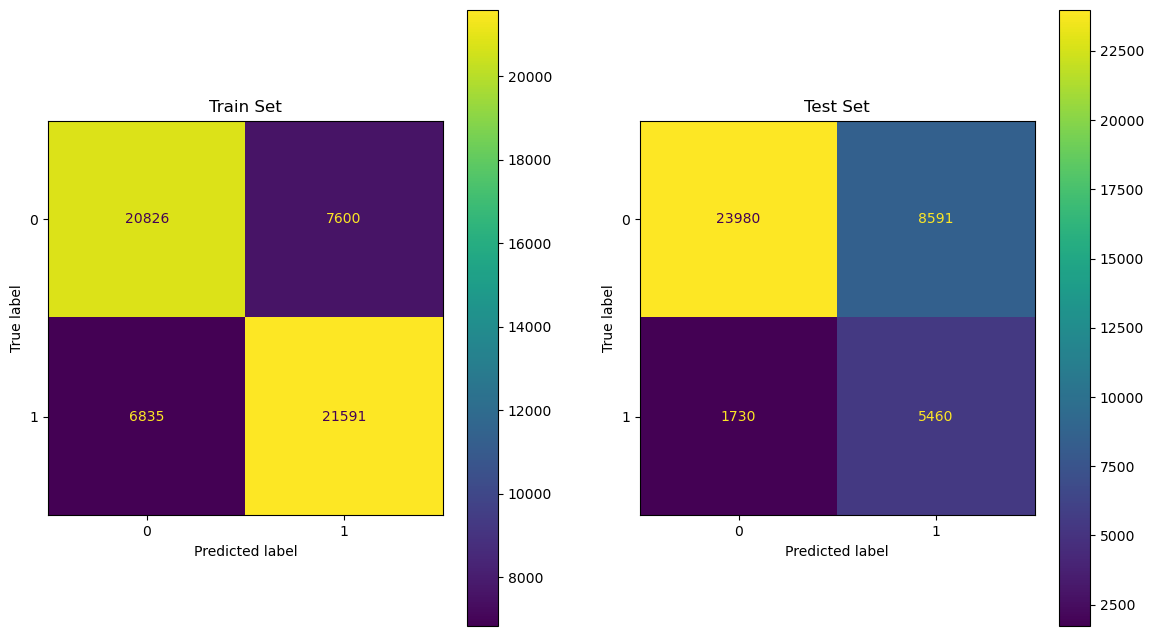

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

y_pred_train_dt = clf.predict(X_train)
y_pred_test_dt = clf.predict(X_test)


performance_df = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_dt),
                                         precision_score(y_train, y_pred_train_dt),
                                         recall_score(y_train, y_pred_train_dt)],
                               'Test': [accuracy_score(y_test, y_pred_test_dt),
                                        precision_score(y_test, y_pred_test_dt),
                                        recall_score(y_test, y_pred_test_dt)]})

display(performance_df)

fig, ax = plt.subplots(1,2, figsize=(14,8))


#print("Confusion matrix for the train set")
#print(confusion_matrix(y_train,y_pred_train_dt).T)
plot_confusion_matrix(clf,X_train,y_train,ax=ax[0], values_format = 'd')
ax[0].title.set_text("Train Set")

#print("Confusion matrix for the test set")

#print(confusion_matrix(y_test,y_pred_test_dt).T)
plot_confusion_matrix(clf,X_test,y_test,ax=ax[1],values_format = 'd')
ax[1].title.set_text("Test Set")

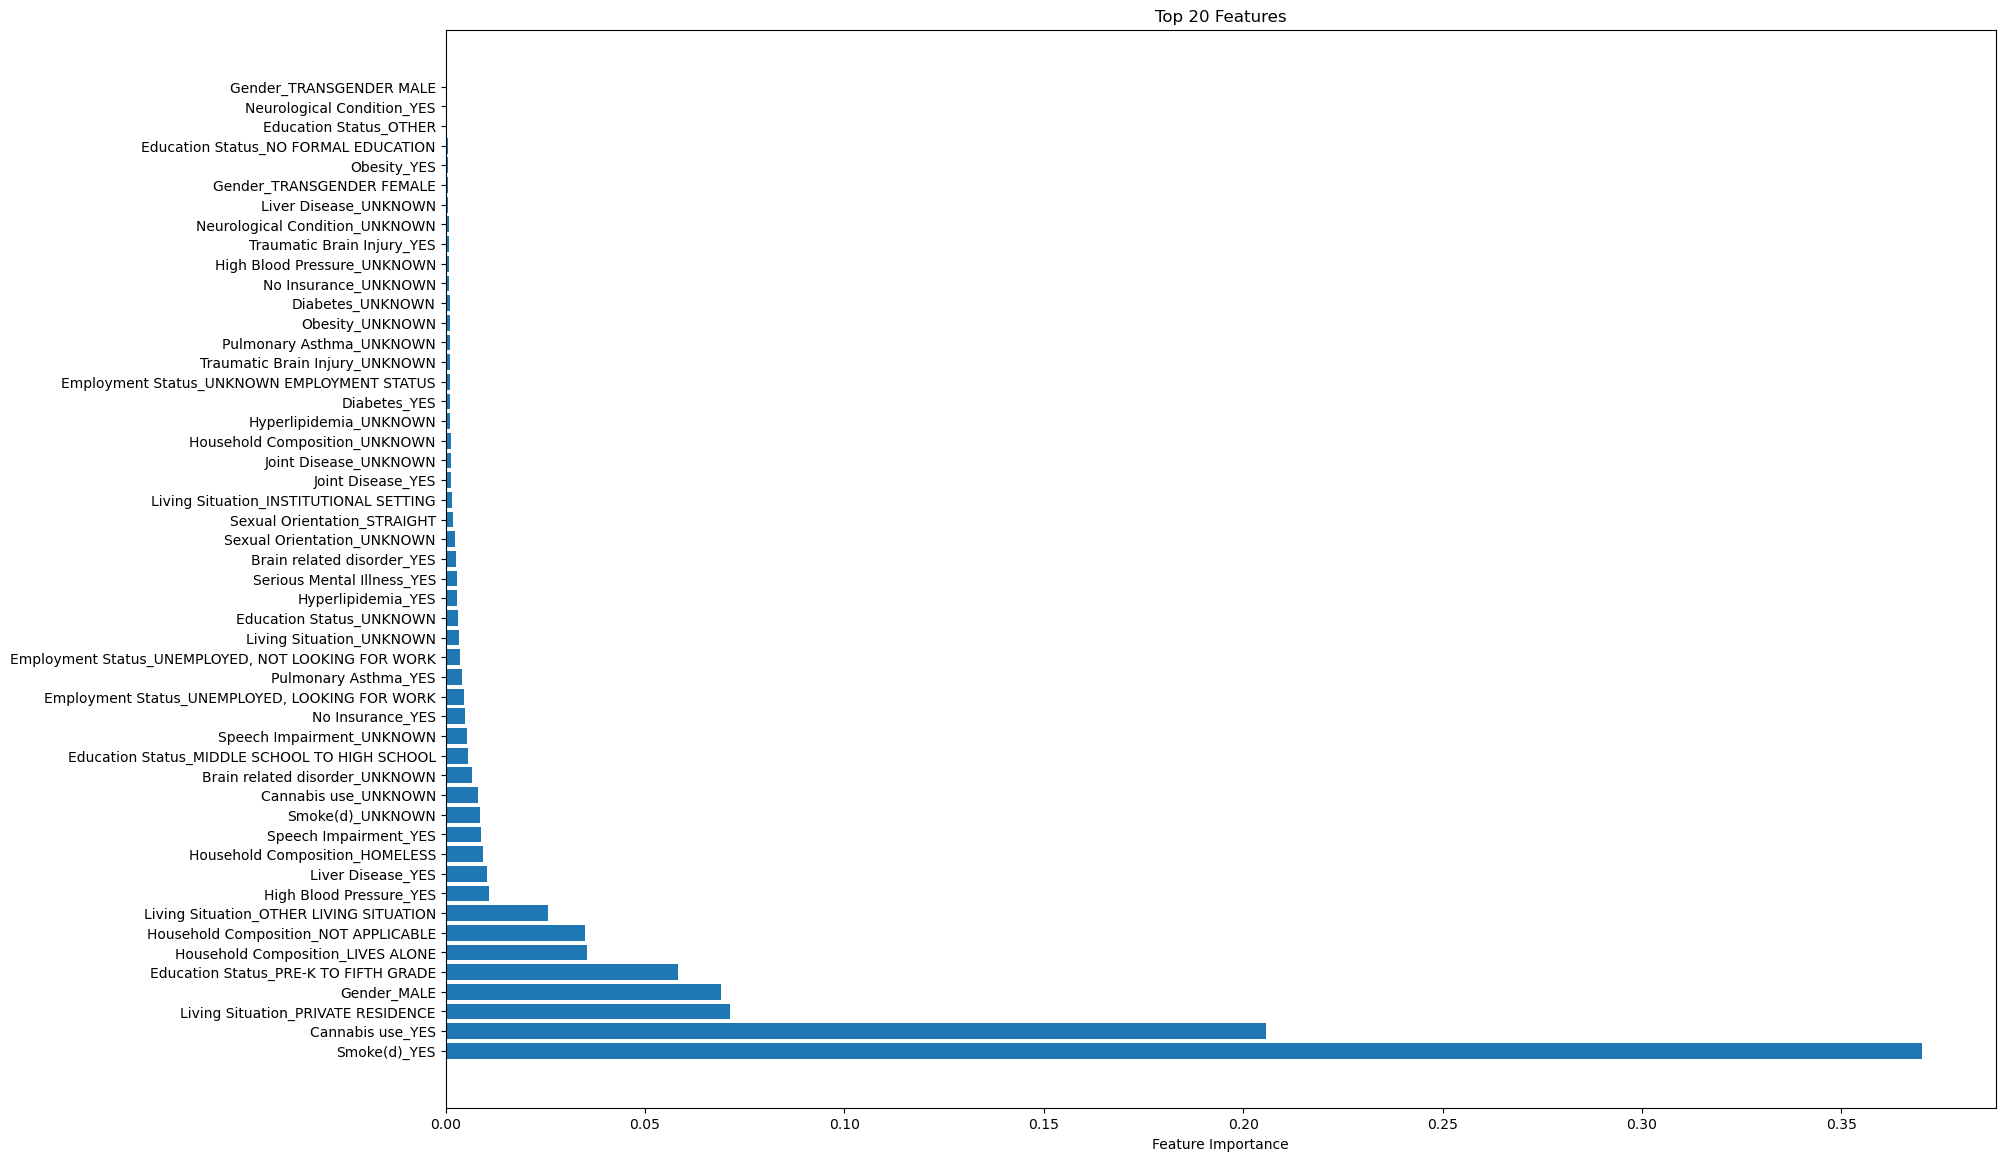

In [50]:
# Sort the features and select only top50
sorted_features = np.argsort(clf.feature_importances_)[::-1]
top20_features = sorted_features[:50]

# Plot horizontal bar chart of top 50 features
plt.figure(figsize=(20, 14))
plt.barh(X_encod.columns[top20_features], clf.feature_importances_[top20_features])
plt.xlabel("Feature Importance")
plt.title("Top 20 Features")
plt.show()